# **Desafío - Mecanismos de Votación**
---
### Nombre: Thomas Peet, Braulio Aguila, Camilo Ramírez
### Generación: G47
### Profesores: Alfonso Tobar - Sebastián Ulloa
### Fecha: 21-09-2022
---

>### **Requerimientos**
Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o impopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39797 registros, donde cada uno representa características del artículo publicado en el sitio web. Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity
of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.. Los artículos registrados son de la página web.  
Más información sobre los atributos se puede encontrar en el archivo ``OnlineNewsPopularity.names``.

>>### **Ejercicio 1 - Preparación del Ambiente de Trabajo**
* A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función ``grid_plot_batch`` que se encuentra en el archivo ``helpers.py``.
````PYTHON
    # las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
    df.columns = [i.replace(' ', '') for i in df.columns]
    # eliminamos el string de url que no sirve para el análisis
    df = df.loc[:, 'n_tokens_title':'shares']
    # generamos el conjunto de variables
    qnty = df.filter(regex='^n_', axis=1)
    channel = df.filter(regex='^data_', axis=1)
    days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
    sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
    lda = df.filter(regex='^LDA_\d', axis=1)
    keywords = df.filter(regex='^kw_', axis=1)

````
* Describa el comportamiento de las variables.
* Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función ``identify_high_correlations`` que se encuentra en el archivo ``helpers.py``. Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.
* Antes de generar los conjuntos de entrenamiento y validación, pre procese los datos con los siguientes pasos:
* Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable shares posteriormente.
* Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
* Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn import set_config
set_config(display='diagram')

import utils 
import helpers

import re

In [2]:
df_init = pd.read_csv('OnlineNewsPopularity.csv',).drop(labels=31037, axis=0) # se elimina el dato 31037 pq tiene columnas erroneas que arruinan algunos gráficos.
df_init.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [3]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df = df_init.copy()
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)
df.head()


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


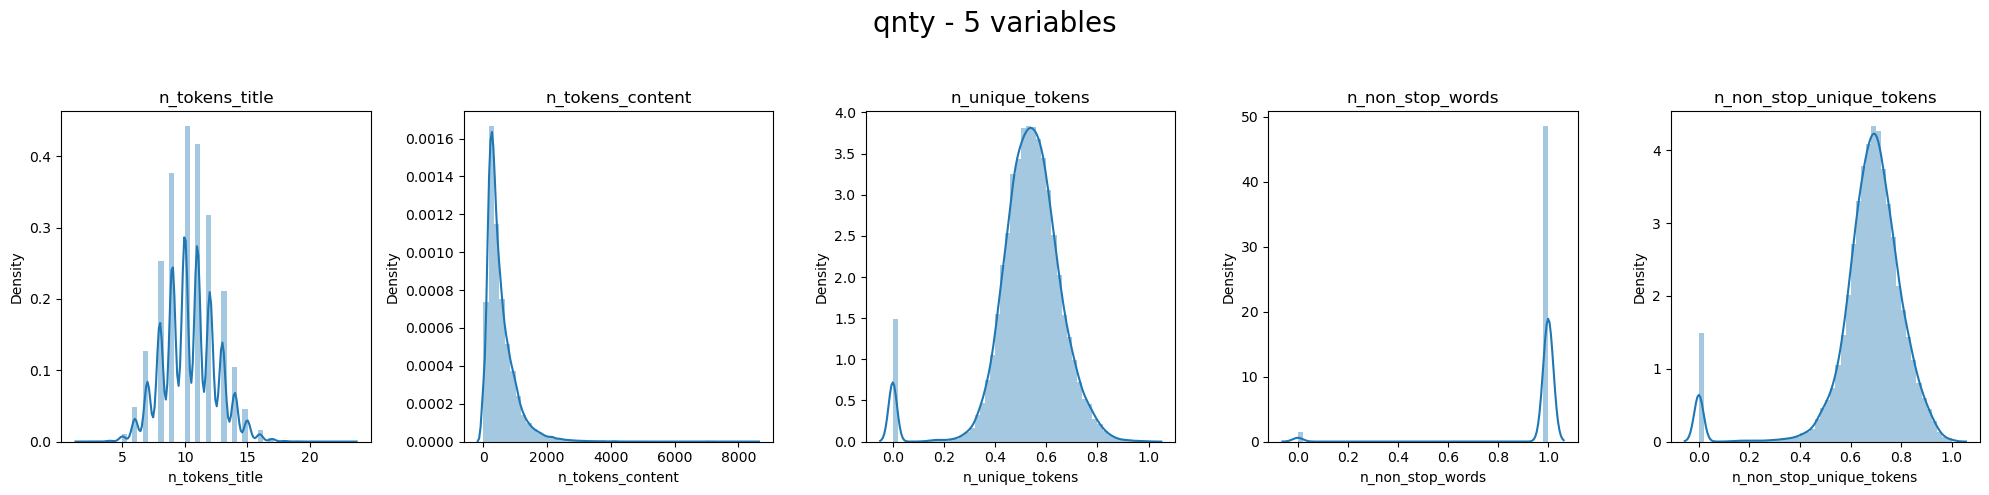

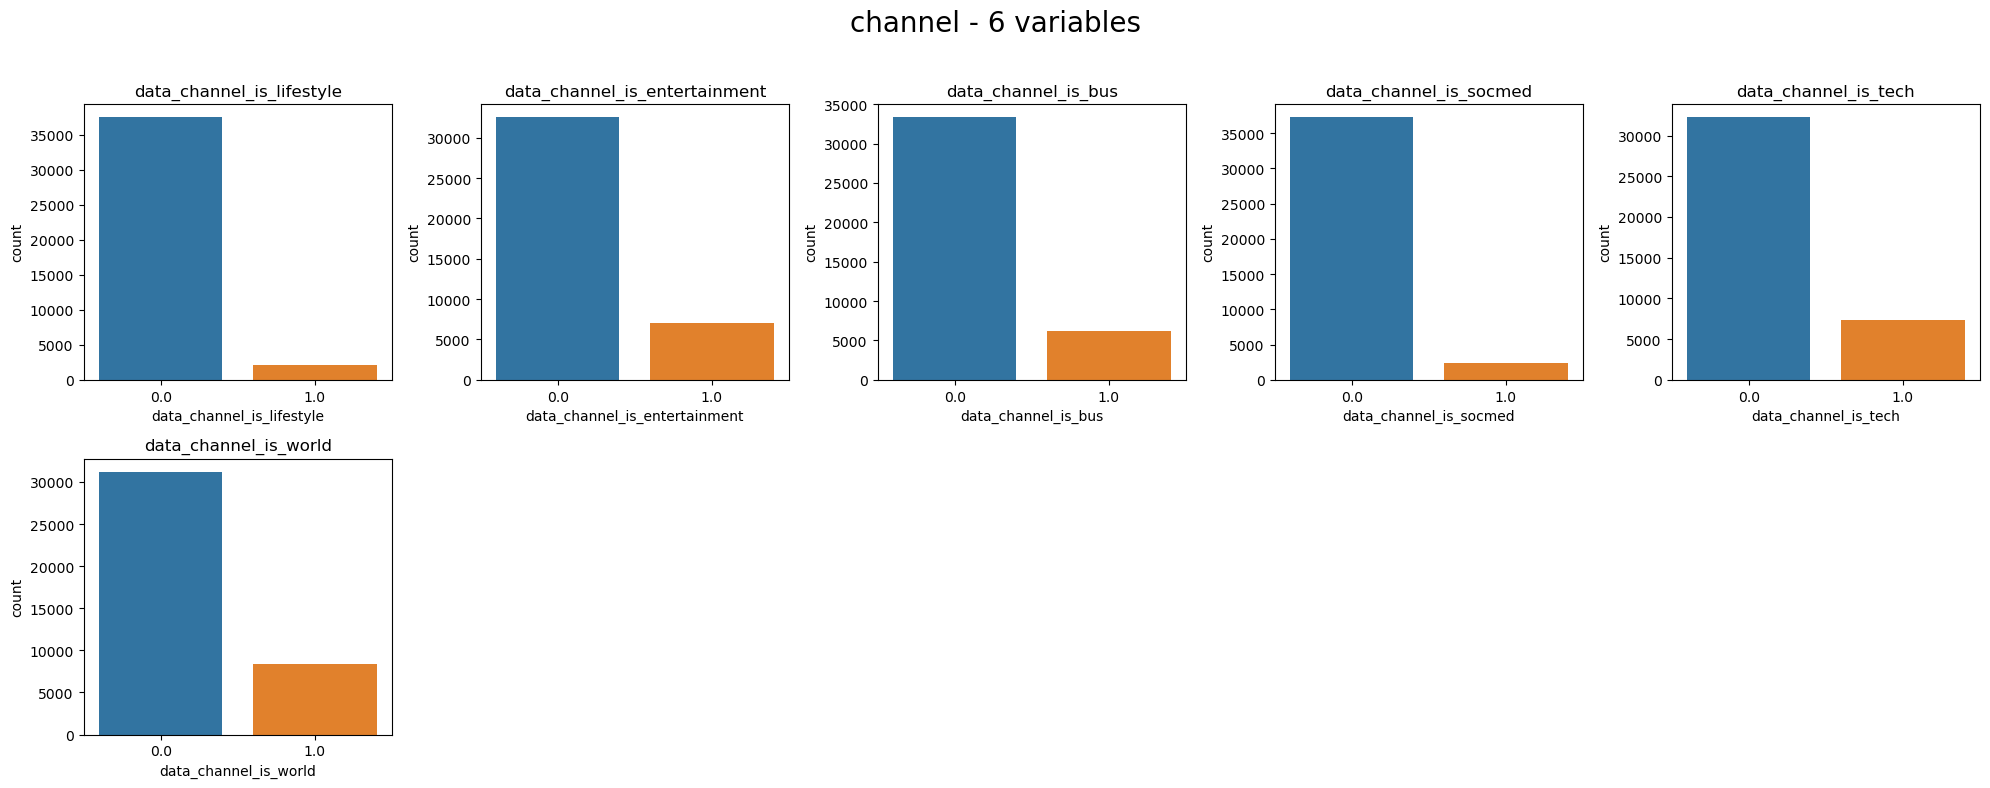

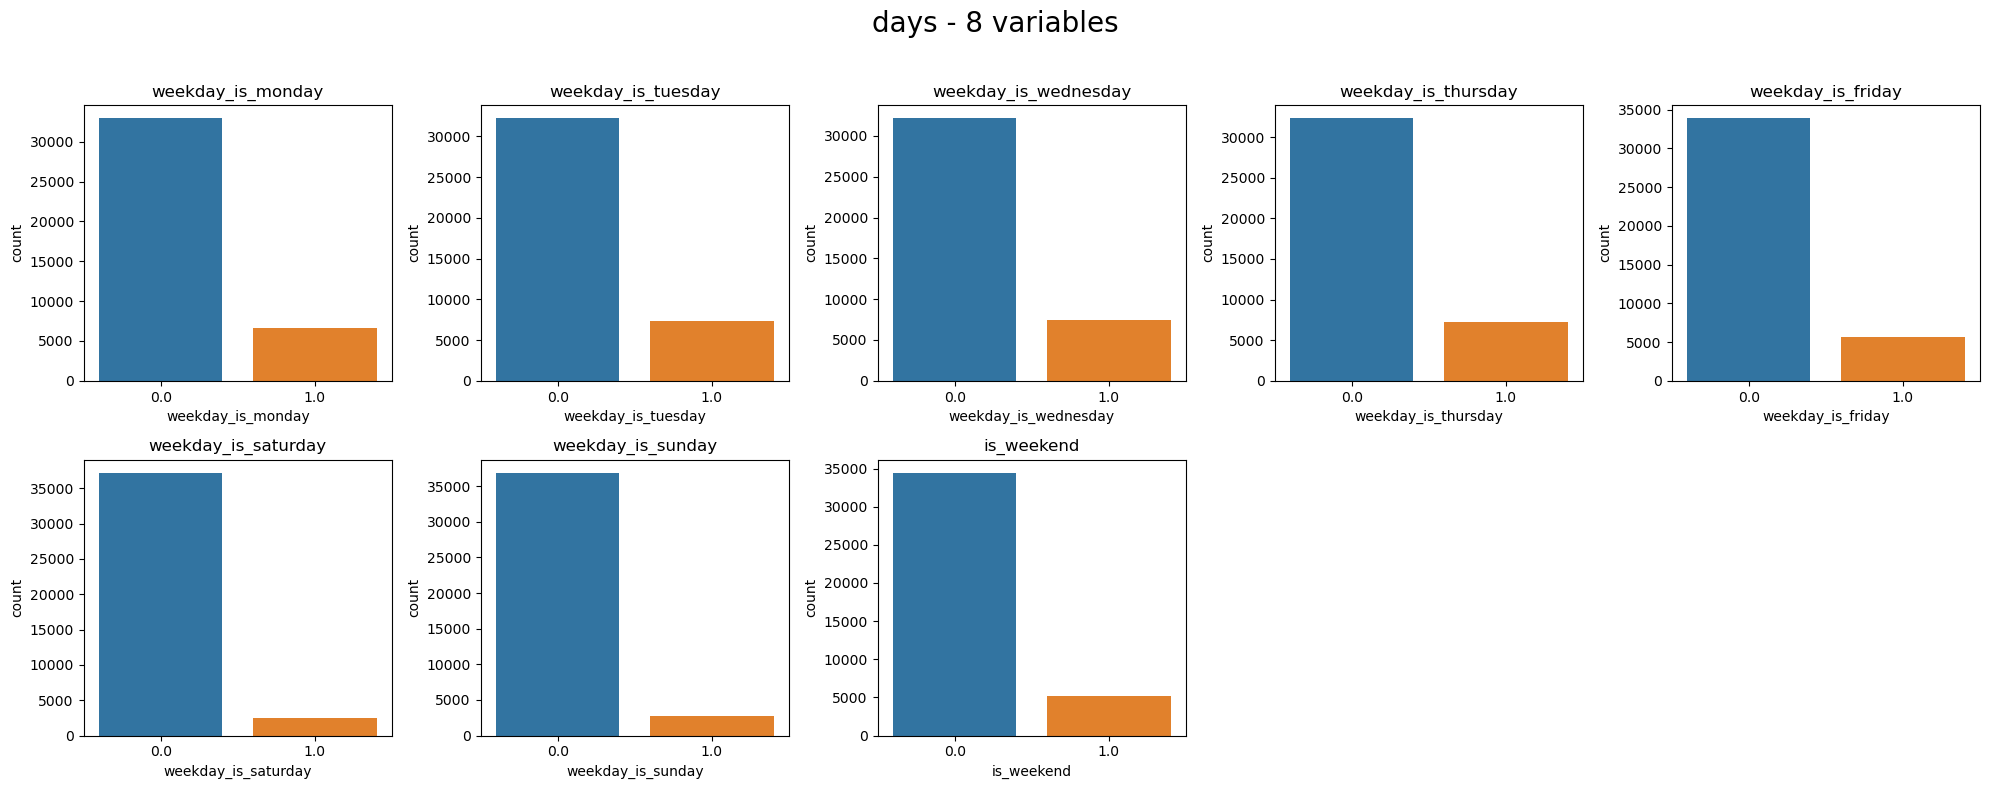

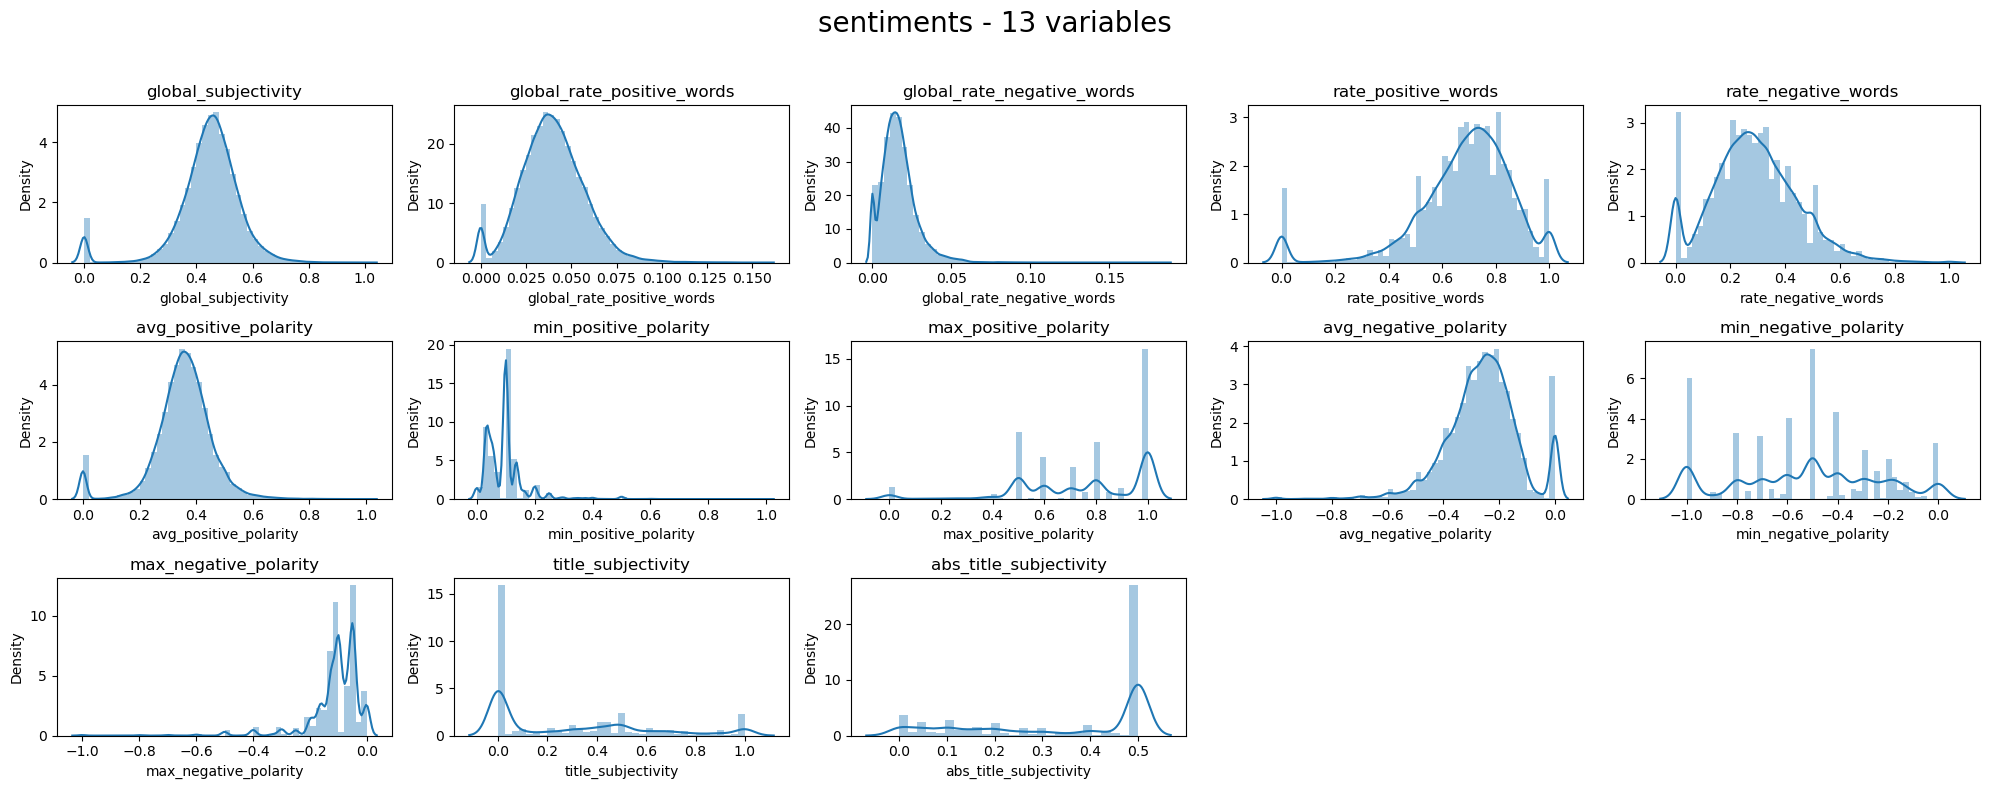

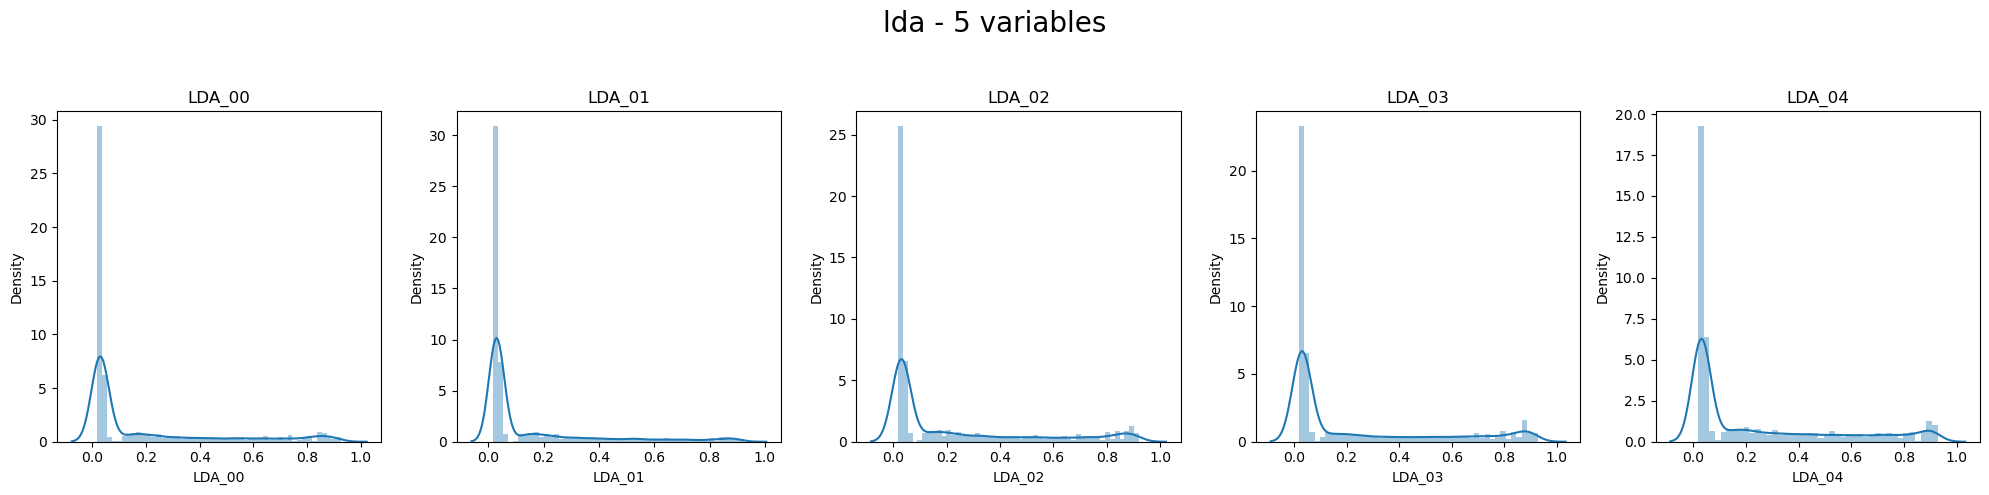

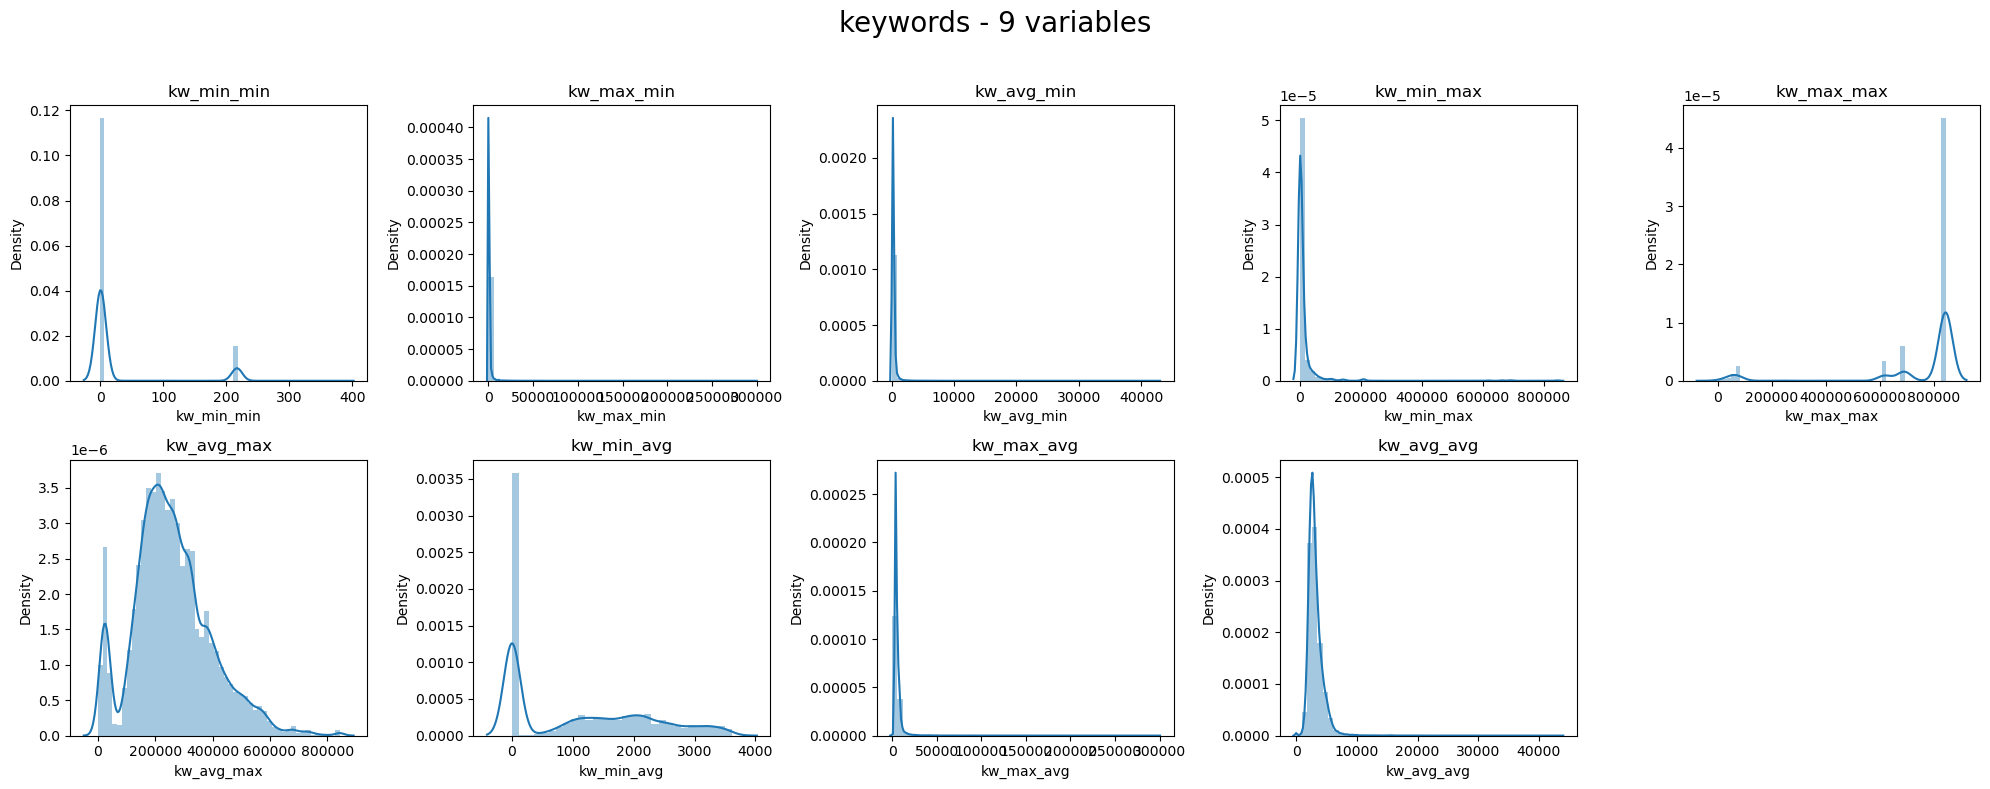

In [4]:
groups = {
            "qnty": (qnty, sns.distplot, 5), 
            "channel": (channel, sns.countplot, 8), 
            "days": (days, sns.countplot, 8),
            "sentiments": (sentiments, sns.distplot, 8),
            "lda": (lda, sns.distplot,5 ),
            "keywords": (keywords, sns.distplot,8 )
}
import warnings
warnings.filterwarnings("ignore")
for k,v in groups.items():
    a=1
    plt.figure(figsize=(20,v[2])).suptitle(f"{k} - {len(v[0].columns)} variables\n" , fontsize=20)
    helpers.grid_plot_batch(v[0], 5, v[1])

>>### Comentarios
En general las variables numéricas tienen comporamientos similares a una gaussiana en la mayoría de los casos (grupo `qnty`, `sentiments`, `lda`, `keywords`) aunque hay variables que tienen más de una moda

Las variables binarias, en general presentan una distribución desbalanceada a la clase 0, pero es esperable por la naturaleza de las variables (preguntas binarias en variables multiclase)

In [5]:
helpers.identify_high_correlations(df,.8)

,variable,var2,value
238,n_non_stop_unique_tokens,n_unique_tokens,0.937679
534,average_token_length,n_non_stop_words,0.943846
1139,kw_avg_min,kw_max_min,0.940529
1256,kw_max_max,kw_min_min,-0.857226
1499,kw_avg_avg,kw_max_avg,0.811864
1678,self_reference_avg_sharess,self_reference_min_shares,0.818907
1679,self_reference_avg_sharess,self_reference_max_shares,0.853481
2317,LDA_02,data_channel_is_world,0.836617


>>### **Ejercicio 2 - Evaluación de modelos individuales**
* A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
    * Importe los módulos correctamente.
    * Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a Precision, Recall, F1. Puede hacer uso de la función
    ``plot_classification_report`` disponible en el archivo ``helpers.py``.
    * Comente el desempeño general de cada uno.
* La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    * Regresión Logística.
    * Algoritmo de KMedias.
    * Árbol de Clasificación con un ``max_depth=1``.
    * Árbol de Clasificación con un ``max_depth=4``.

In [6]:
X = df
X

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,4.405488,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,1.0,5.076923,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,0.0,4.975073,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


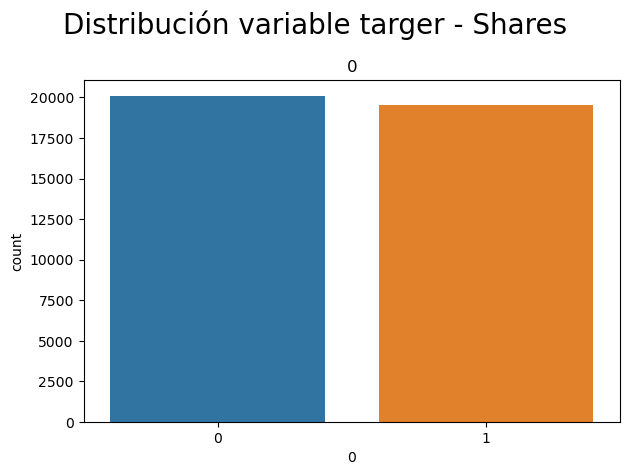

In [7]:
from helpers import PreprocBCT

y = df.shares
X = df.drop(columns='shares')

y = np.where(y>1400, 1, 0)

plt.figure().suptitle(f"Distribución variable targer - Shares" , fontsize=20)
helpers.grid_plot_batch(pd.DataFrame(y), 1, sns.countplot)

In [8]:
prep = Pipeline(steps=[
    ('sc', SklearnTransformerWrapper(StandardScaler(), variables=qnty.columns.to_list() + sentiments.columns.to_list() + lda.columns.to_list()  + keywords.columns.to_list())),
    ('paso1', PreprocBCT(under=1400, threshold=.8)),   # Las transformaciones pedidas en el enunciado fueron aplicadas en una clase aparte.
    ('pca', PCA(n_components = 30, random_state=123))
])
# X_n = pd.DataFrame(prep.fit_transform(X))

In [9]:
# Variables eliminadas por alta correlación
prep.fit(X)
prep['paso1'].variables_eliminidas

['n_unique_tokens',
 'n_non_stop_words',
 'kw_max_min',
 'kw_min_min',
 'kw_max_avg',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'data_channel_is_world']

>>### Comentarios
Podemos observar que las variables descartadas según el criterio de correlación son las siguientes:
- `n_unique_tokens`
- `n_non_stop_words`
- `kw_max_min`
- `kw_min_min`
- `kw_max_avg`
- `self_reference_min_shares`
- `self_reference_max_shares`
- `data_channel_is_world`

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

In [17]:
estimators = [
    ('lr', LogisticRegression(random_state=123)),
    ('gnb', GaussianNB()), # Se cambio KMeans por SVC ya que KMeans no es un clasificador supervisado
    ('dt_1', DecisionTreeClassifier(max_depth=1, random_state=123)),
    ('dt_4', DecisionTreeClassifier(max_depth=4, random_state=123))
]

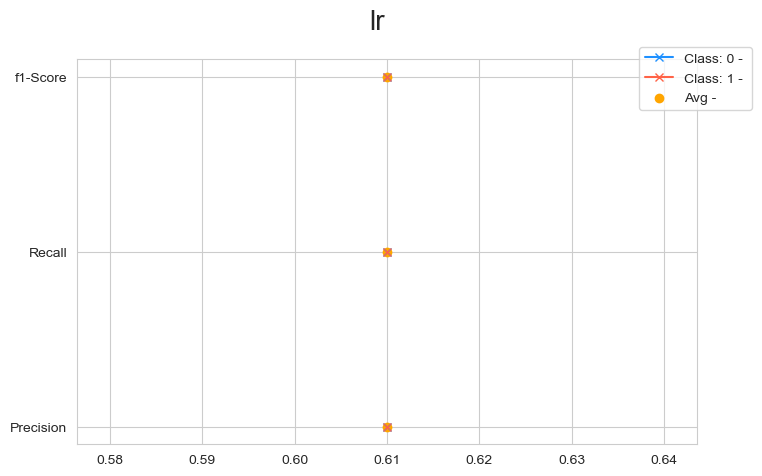

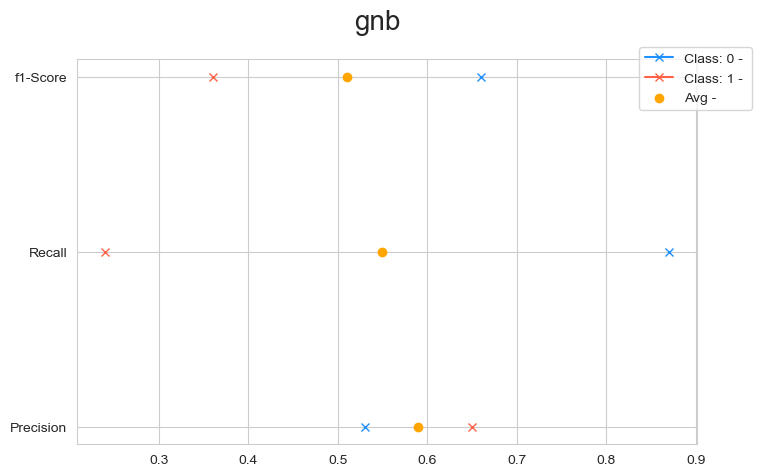

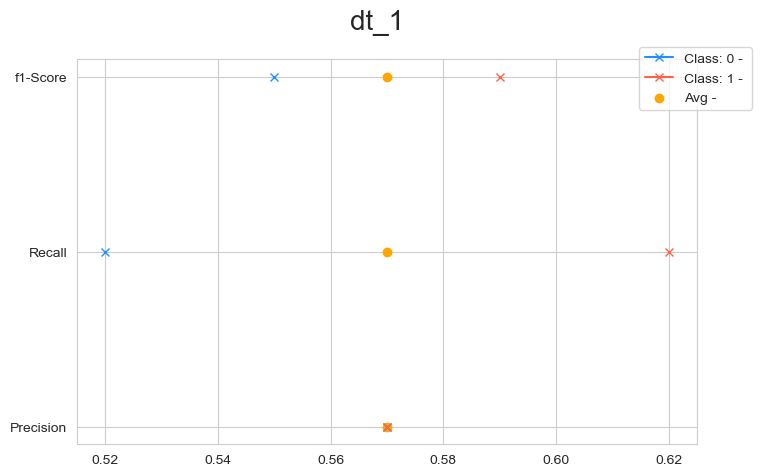

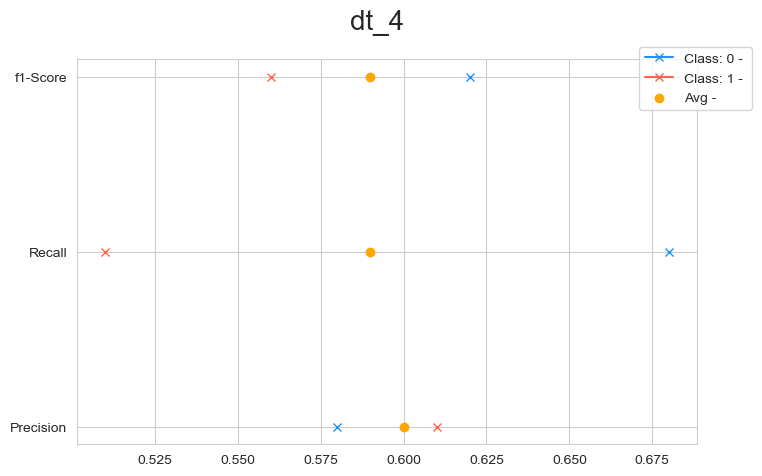

In [18]:
pipes_simples = {}
y_preds = {}
for est in estimators:
    pipes_simples[est[0]] = Pipeline(steps=[
                ('prep', prep),
                ('model', est[1])
            ])
    
    pipes_simples[est[0]] .fit(X_train, y_train)
    y_preds[est[0]] = pipes_simples[est[0]].predict(X_test)
    plt.figure(figsize=(8,5)).suptitle(f"{est[0]}" , fontsize=20)
    helpers.plot_classification_report(y_test, y_preds[est[0]], '')

>>### **Ejercicio 3 - Entrenamiento de Comité**
* Entrene el comité de clasificadores sin modificar el esquema de votación.
* Reporte el desempeño a nivel de cada clase para cada métrica.

In [19]:
pipe_hard = Pipeline(steps=[
    ('prep', prep),
    ('model', VotingClassifier(estimators, voting = 'hard', n_jobs=-1)) #voting = hard, cuento la cantidad de votos que entrega cada modelo. 
])
pipe_hard.fit(X_train, y_train)
y_pred_hard = pipe_hard.predict(X_test)


>>### **Ejercicio 4 - Calibración de Comité con Ponderadores**
* En base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
* Reporte el desempeño del mejor ensamble heterogéneo.

In [20]:
pipe_soft = Pipeline(steps=[
    ('prep', prep),
    ('model', VotingClassifier(estimators, voting='soft', n_jobs=-1))  # voting = soft
])

pipe_soft.fit(X_train, y_train)
y_pred_soft = pipe_soft.predict(X_test)


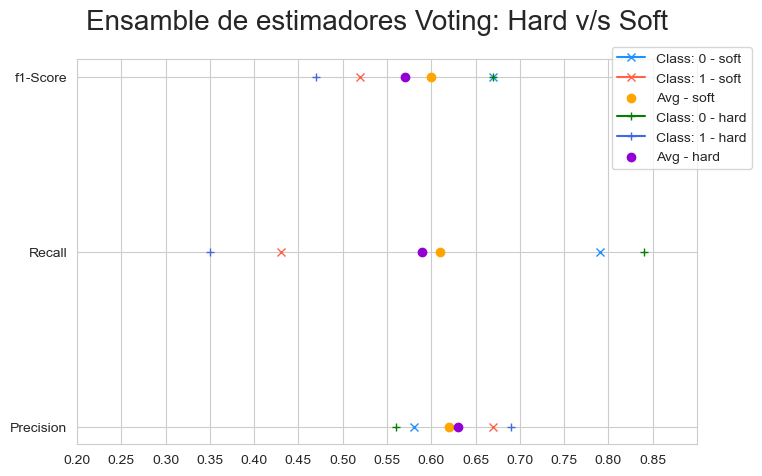

In [21]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5)).suptitle("Ensamble de estimadores Voting: Hard v/s Soft", fontsize=20)
helpers.plot_classification_report(y_test, y_pred_soft, 'soft')
helpers.plot_classification_report(y_test, y_pred_hard, 'hard')
plt.xlim(0.2, 0.9)
plt.xticks(np.arange(0.2, 0.9, step=0.05));


>> ### Comentarios

Según la métrica del recall podemos afirmar que él método de votación soft es capaz de identificar más casos de posteos clasificados como "virales" aún cuando se equivoque clasificando más casos "no virales" como "virales".

Según la precision, el método de votación hard es más fino en el análisis y se equivoca menos en la detección de posteos que efectivamente eran virales.

En este caso, sería mejor clasificar que posteos son virales intentando equivocarse menos ya que sería más grave identificar una noticia de importancia como viral que en el caso contrario.
